# 특성공학

- 교차검증 소개
- 차원 축소
- SelectKBest
- PCA
- t-SNE

# 차원축소
## 차원 선택(축소) 방법
- 1) 사람이 경험으로 선택하는 방법
- 2) SelectKBest: 목적 변수와의 상관 관계가 큰 특성 선택
- 3) PCA: 특성(입력 변수들) 간의 독립적인 성분을 기준으로 차원을 축소

## 시각화를 위한 차원 축소
- t-SNE: 시각화를 위한 2또는 3차원 차원 축소 

# import

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
%config InlineBackend.figure_format="retina"

In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import feature_selection
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [22]:
## 유방암 발생 데이터 다운로드

cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target
print(X.shape)
X[:3]

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [23]:
cancer.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [24]:
type(cancer)

sklearn.utils._bunch.Bunch

In [25]:
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

## 교차 검증


In [26]:
## 교차 검증을 수행하는 함수 정의

# n 세트의 훈련용과 검증용 데이터를 랜덤하게 나눈다
# 디폴트 값은 shuffle=False이므로 이를 True로 바꾸어주어야 한다
# 아래는 train_test_split을 5번 수행하고 평균을 구하는 것과 유사하다

def cross_validation(model, X, y, n=5): 
    cv = KFold(n, shuffle=True)
    return cross_val_score(model, X, y, cv=cv).mean().round(4)

# 랜덤 포레스트 모델 사용

## 30개의 특성을 모두 사용
- 가장 성능이 좋은 경우

In [27]:
## 30개 특성을 이용한 랜덤 포레스트 분류 모델

rfc = RandomForestClassifier()
cross_validation(rfc, X, y, 5)

0.9542

# SelectKBest

- 목적변수 y와의 상관 관계가 큰 특성을 k개 선택

In [28]:
## 목적변수 y와의 상관 관계가 큰 특성을 k개 선택

from sklearn.feature_selection import SelectKBest, chi2
sb = SelectKBest(chi2, k=2)
X_best = sb.fit_transform(X, y)
print(X_best.shape)

# 선택된 특성 컬럼명 보기
print('Selected Features: ')
print(list(X.columns[sb.get_support()]))
cross_validation(rfc, X_best, y)

(569, 2)
Selected Features: 
['mean area', 'worst area']


0.9297

In [29]:
sb.get_support()

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False])

## 두개 특성의 산포도 그리기

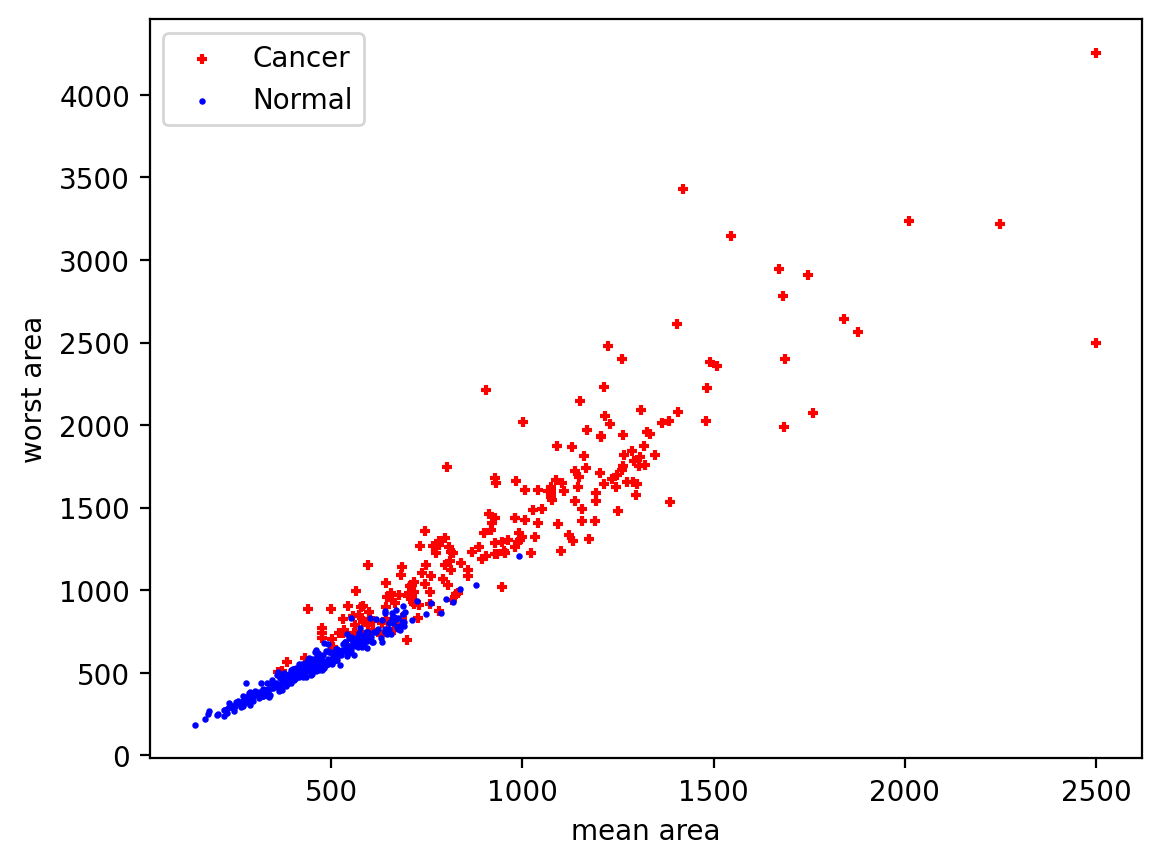

In [30]:
## 두 개 특성의 산포도 그리기

plt.scatter(X_best[:,0][y==0],X_best[:,1][y==0],
            marker='+', s=13, color='r', label='Cancer')
plt.scatter(X_best[:,0][y==1],X_best[:,1][y==1],
            marker='.', s=7, color='b', label='Normal')
plt.xlabel('mean area')
plt.ylabel('worst area')
plt.legend()

# PCA를 사용한 차원 축소

## PCA 개념
<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-10-04%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%209.24.09.png?raw=1" align='left'  width=300>

0.9262


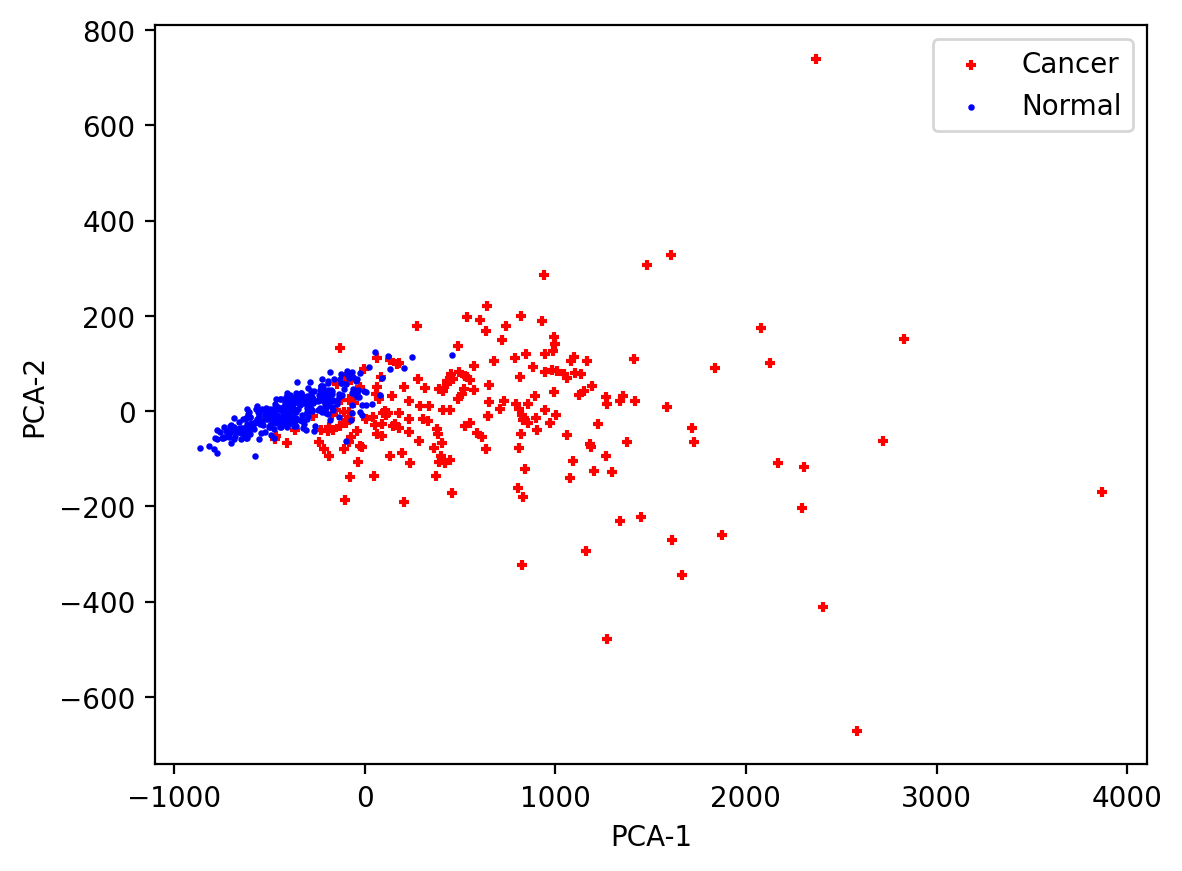

In [31]:
## 2개의 주성분(PCA) 사용 결과

pca = PCA(2)
X_pca = pca.fit_transform(X)
print(cross_validation(rfc, X_pca, y))

# 두 개 주성분을 축으로 산포도 그리기
plt.scatter(X_pca[:,0][y==0],X_pca[:,1][y==0],
            marker='+', s=13, color='r', label='Cancer')
plt.scatter(X_pca[:,0][y==1],X_pca[:,1][y==1],
            marker='.', s=7, color='b', label='Normal')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend()

## pca 생성에 사용한 가중치

In [32]:
## pca 생성시에 가중합을 사용한다. 가중치를 보는 내부 변수

print(pca.components_.round(3))

[[ 0.005  0.002  0.035  0.517  0.     0.     0.     0.     0.    -0.
   0.    -0.     0.002  0.056 -0.     0.     0.     0.    -0.    -0.
   0.007  0.003  0.049  0.852  0.     0.     0.     0.     0.     0.   ]
 [ 0.009 -0.003  0.063  0.852 -0.    -0.     0.     0.    -0.    -0.
  -0.     0.     0.001  0.008  0.     0.     0.     0.     0.     0.
  -0.001 -0.013 -0.    -0.52  -0.    -0.    -0.    -0.    -0.    -0.   ]]


- PCA는 샘플을 저차원 특성공간에서 (보통 2차원) 분포를 파악할 때 자주 사용된다 
<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-05-30%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%209.31.41.png?raw=1" align='left'  width=400>

# t-SNE 시각화

- T-distributed Stochastic Neighbor Embedding
- 실행할 때마다 다른 패턴을 보여준다
- perplexity를 바꾸면 그림이 다르게 나타난다
- 데이터를 설명하기 가장 좋은 그림을 택하면 된다
- PCA의 2차원 패턴은 하나로 고정된다

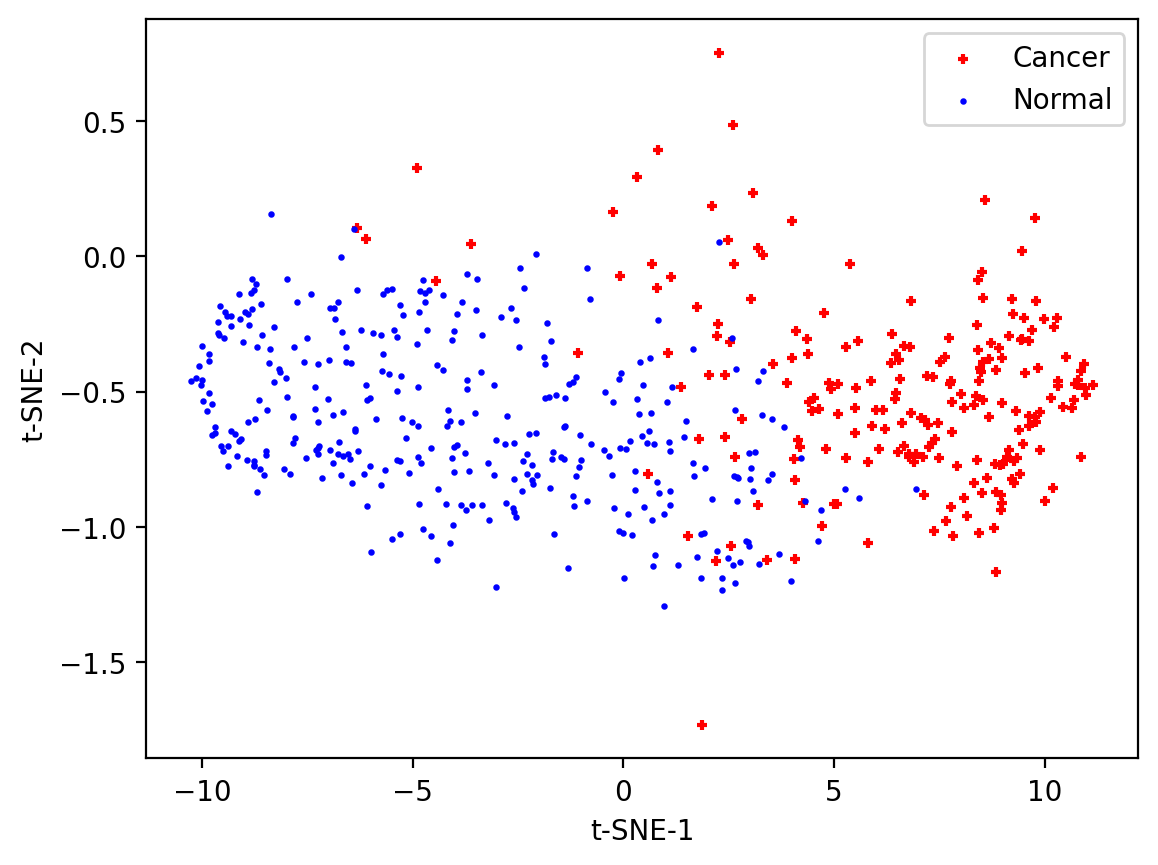

In [33]:
## 2차원 t-SNE 수행과 시각화

tsne = TSNE(2, perplexity=150)
tsne_2 = tsne.fit_transform(X)


plt.scatter(tsne_2[:,0][y==0],tsne_2[:,1][y==0],
            marker='+', s=13, color='r', label='Cancer')
plt.scatter(tsne_2[:,0][y==1],tsne_2[:,1][y==1],
            marker='.', s=7, color='b', label='Normal')

plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.legend()

# (실습) PCA 차원수
- PCA 차원수를 늘리면서 성능의 개선을 확인하시오
- PCA 차원수를 2~10 범위에서 모델의 성능을 확인한다

## (정답)

In [34]:
result = []

for k in range(2,11):
    pca = PCA(k)
    X_pca = pca.fit_transform(X)
    result.append((k, cross_validation(rfc, X_pca, y)))

<Axes: xlabel='k'>

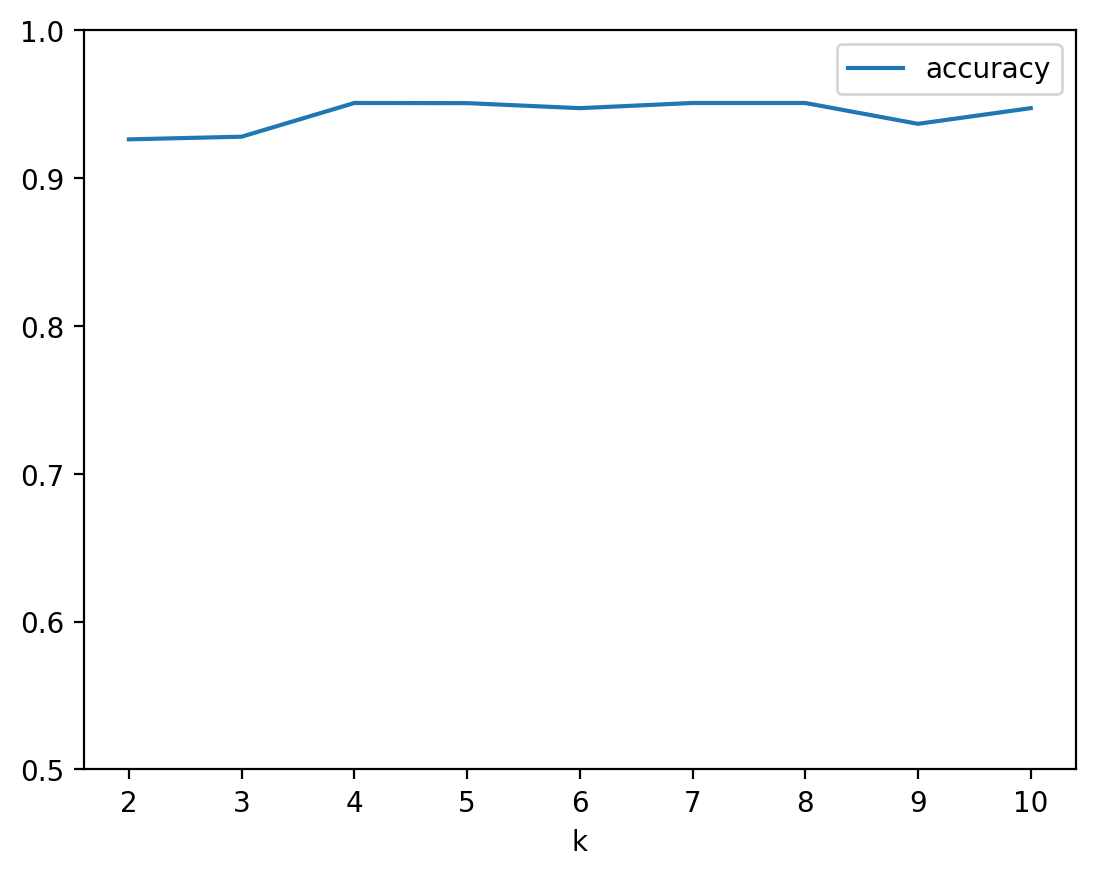

In [35]:
df = pd.DataFrame(result, columns=['k','accuracy'])
df = df.set_index('k')
df.plot(ylim=(0.5,1))